In [1]:
import geopandas as gpd
from scipy.spatial.distance import cdist
import numpy as np
import math
import matplotlib.pyplot as plt

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

Read data

In [2]:
cook_centroids = gpd.read_file('data/cook_centroids_all.shp')
n1 = cook_centroids.shape[0]
cook_centroids.columns, n1

(Index(['GISJOIN', 'Lon_w', 'Lat_w', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID',
        'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
        'INTPTLON', 'Shape_Leng', 'Shape_Area', 'ORIG_FID', 'YEAR', 'STUSAB',
        'REGIONA', 'DIVISIONA', 'STATE', 'STATEA', 'COUNTY', 'COUNTYA',
        'COUSUBA', 'PLACEA', 'TRACTA', 'BLKGRP', 'CONCITA', 'AIANHHA',
        'RES_ONLYA', 'TRUSTA', 'AIHHTLI', 'AITSA', 'ANRCA', 'CBSAA', 'CSAA',
        'METDIVA', 'NECTAA', 'CNECTAA', 'NECTADIVA', 'UAA', 'CDCURRA', 'SLDUA',
        'SLDLA', 'ZCTA5A', 'SUBMCDA', 'SDELMA', 'SDSECA', 'SDUNIA', 'PCI',
        'PUMAA', 'GEO_ID', 'BTTRA', 'BTBG', 'TL_GEO_ID', 'NAME_E', 'NAME_M',
        'S1', 'S2', 'A1', 'A2', 'A3', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7',
        'HHI1', 'HHI2', 'HHI3', 'Total_Pop', 'Total_HH', 'geometry'],
       dtype='object'),
 1331)

User-defined parameters

In [3]:
p = 100
s = 1000
t = 0.1

Distance matrix

In [4]:
points = cook_centroids['geometry'].apply(lambda geom: (geom.x, geom.y)).tolist()
D = cdist(points, points, metric='euclidean')
D, D.shape

(array([[    0.        ,  1082.87422978,   661.44521516, ...,
         19026.12158013, 19802.36119962, 26772.50604907],
        [ 1082.87422978,     0.        ,   671.36097906, ...,
         18306.97279514, 18782.33657054, 26010.24087613],
        [  661.44521516,   671.36097906,     0.        , ...,
         18377.69148671, 19431.02947413, 26118.43883191],
        ...,
        [19026.12158013, 18306.97279514, 18377.69148671, ...,
             0.        , 21225.23955835,  7820.49208496],
        [19802.36119962, 18782.33657054, 19431.02947413, ...,
         21225.23955835,     0.        , 25218.70463641],
        [26772.50604907, 26010.24087613, 26118.43883191, ...,
          7820.49208496, 25218.70463641,     0.        ]]),
 (1331, 1331))

Coverage

In [14]:
# discrete
A = np.zeros((n1, n1))
for i in range(n1):
    for j in range(n1):
        if D[i, j] <= s:
            A[i, j] = 1
A, A.shape

(array([[1., 0., 1., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 (1331, 1331))

In [5]:
# continuous
A = np.zeros((n1, n1))
for i in range(n1):
    for j in range(n1):
        A[i, j] = math.exp(-t * D[i, j] / s)
A, A.shape

(array([[1.        , 0.89736963, 0.93599558, ..., 0.14917843, 0.13803664,
         0.06875192],
        [0.89736963, 1.        , 0.93506793, ..., 0.16030175, 0.15285987,
         0.07419755],
        [0.93599558, 0.93506793, 1.        , ..., 0.15917212, 0.14325874,
         0.07339908],
        ...,
        [0.14917843, 0.16030175, 0.15917212, ..., 1.        , 0.11972906,
         0.4574676 ],
        [0.13803664, 0.15285987, 0.14325874, ..., 0.11972906, 1.        ,
         0.08030925],
        [0.06875192, 0.07419755, 0.07339908, ..., 0.4574676 , 0.08030925,
         1.        ]]),
 (1331, 1331))

Demand

In [6]:
# groups = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6']
groups = ['S1', 'S2']
n2 = len(groups)
W = cook_centroids[groups].to_numpy()

MOO-theil

In [7]:
class MCLPE3(ElementwiseProblem):
    def __init__(self, w, a, p):
        super().__init__(n_var=a.shape[1], n_obj=2, n_ieq_constr=1, xl=0, xu=1, vtype=bool)
        self.w = w
        self.a = a
        self.p = p

    def _evaluate(self, x, out, *args, **kwargs):
        y = np.max(x * self.a, axis=1)

        # Objective 1
        obj1 = np.sum(np.sum(y * self.w.T, axis=1))

        # # Objective 2
        u_k = np.sum(y * self.w.T, axis=1) / np.sum(self.w, axis=0)
        u_bar = np.mean(u_k)
        obj2 = 1 / self.w.shape[1] * np.sum(u_k / u_bar * np.log(u_k / u_bar))

        constr = np.sum(x) - self.p  # Constraint on the total number of facilities

        out["F"] = [-obj1, obj2]
        out["G"] = [constr]

problem = MCLPE3(W, A, p)

algorithm = NSGA2(
    pop_size=100,
    sampling=BinaryRandomSampling(),
    crossover=TwoPointCrossover(),
    mutation=BitflipMutation(),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 2000)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

F = [res.F]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  5.160000E+02 |  5.641100E+02 |             - |             -
     2 |      200 |      1 |  5.100000E+02 |  5.424300E+02 |             - |             -
     3 |      300 |      1 |  5.060000E+02 |  5.305400E+02 |             - |             -
     4 |      400 |      1 |  5.010000E+02 |  5.212900E+02 |             - |             -
     5 |      500 |      1 |  4.880000E+02 |  5.116500E+02 |             - |             -
     6 |      600 |      1 |  4.840000E+02 |  5.026400E+02 |             - |             -
     7 |      700 |      1 |  4.780000E+02 |  4.946500E+02 |             - |             -
     8 |      800 |      1 |  4.720000E+02 |  4.876100E+02 |             - |             -
     9 |      900 |      1 |  4.630000E+02 |  4.811700E+02 |             - |             -
    10 |     1000 |      1 |  4.630000E+02 |  4.754000E+02 |             - |             -

KeyboardInterrupt: 

In [18]:
print("Best solution found: %s" % res.X.astype(int))
print("Function value: %s" % res.F)
print("Constraint violation: %s" % res.CV)

Best solution found: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Function value: [[-4.41047953e+06  3.80656193e-18]
 [-4.46454434e+06  1.83028951e-17]
 [-4.47374489e+06  2.01379966e-16]
 [-4.47938597e+06  3.48027287e-15]
 [-4.47556725e+06  2.92096550e-15]
 [-4.48382106e+06  5.95705428e-09]
 [-4.48448136e+06  2.57425121e-08]
 [-4.48418714e+06  1.13898819e-08]
 [-4.48388015e+06  8.21447776e-09]
 [-4.48288494e+06  5.90499737e-10]
 [-4.48394031e+06  9.65017270e-09]
 [-4.48437524e+06  2.19320045e-08]
 [-4.48464499e+06  3.22345419e-08]
 [-4.48202042e+06  2.09879217e-14]
 [-4.48435077e+06  1.58306986e-08]
 [-4.48365323e+06  3.35393912e-09]
 [-4.48348960e+06  1.50650482e-09]
 [-4.48356884e+06  3.19232240e-09]
 [-4.48262508e+06  2.06546033e-10]
 [-4.47440516e+06  2.16616180e-16]]
Constraint violation: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [ ]:
F = res.F
plt.figure(figsize=(7, 5))
plt.scatter(-F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

MOO-relative-range

In [20]:
class MCLPE1(ElementwiseProblem):
    def __init__(self, w, a, p):
        super().__init__(n_var=a.shape[1], n_obj=2, n_ieq_constr=1, xl=0, xu=1, vtype=bool)
        self.w = w
        self.a = a
        self.p = p

    def _evaluate(self, x, out, *args, **kwargs):
        y = np.max(x * self.a, axis=1)

        # Objective 1
        obj1 = np.sum(np.sum(y * self.w.T, axis=1))

        # # Objective 2
        u_k = np.sum(y * self.w.T, axis=1) / np.sum(self.w, axis=0)
        u_bar = np.mean(u_k)
        obj2 = (np.max(u_k) - np.min(u_k)) / u_bar

        constr = np.sum(x) - self.p  # Constraint on the total number of facilities

        out["F"] = [-obj1, obj2]
        out["G"] = [constr]

problem = MCLPE1(W, A, p)

algorithm = NSGA2(
    pop_size=100,
    sampling=BinaryRandomSampling(),
    crossover=TwoPointCrossover(),
    mutation=BitflipMutation(),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 2000)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

F.append(res.F)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  5.160000E+02 |  5.641100E+02 |             - |             -
     2 |      200 |      1 |  5.100000E+02 |  5.424300E+02 |             - |             -
     3 |      300 |      1 |  5.060000E+02 |  5.305400E+02 |             - |             -
     4 |      400 |      1 |  5.010000E+02 |  5.212900E+02 |             - |             -
     5 |      500 |      1 |  4.880000E+02 |  5.116500E+02 |             - |             -
     6 |      600 |      1 |  4.840000E+02 |  5.026400E+02 |             - |             -
     7 |      700 |      1 |  4.780000E+02 |  4.946500E+02 |             - |             -
     8 |      800 |      1 |  4.720000E+02 |  4.876100E+02 |             - |             -
     9 |      900 |      1 |  4.630000E+02 |  4.811700E+02 |             - |             -
    10 |     1000 |      1 |  4.630000E+02 |  4.754000E+02 |             - |             -

In [ ]:
print("Best solution found: %s" % res.X.astype(int))
print("Function value: %s" % res.F)
print("Constraint violation: %s" % res.CV)

Best solution found: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Function value: [[-4.37635939e+06  8.37524032e-01]
 [-3.17877157e+06  6.08319049e-01]
 [-4.23122025e+06  8.09736155e-01]
 [-3.54116257e+06  6.77689866e-01]
 [-3.20615754e+06  6.13569976e-01]
 [-3.57719424e+06  6.84588687e-01]
 [-3.94371144e+06  7.54735066e-01]
 [-4.10664915e+06  7.85901832e-01]
 [-4.13390880e+06  7.91112819e-01]
 [-3.91637329e+06  7.49509102e-01]
 [-4.24845902e+06  8.13045738e-01]
 [-3.98492463e+06  7.62631756e-01]
 [-3.78487813e+06  7.24298192e-01]
 [-4.20593441e+06  8.04914535e-01]
 [-3.26454159e+06  6.24736164e-01]
 [-3.96652763e+06  7.59091807e-01]
 [-3.77662850e+06  7.22734338e-01]
 [-3.80299502e+06  7.27789331e-01]
 [-3.60030184e+06  6.89012760e-01]
 [-3.75968000e+06  7.19482275e-01]
 [-3.71504734e+06  7.10941463e-01]
 [-3.36241177e+06  6.43485827e-01]
 [-4.15599723e+06  7.95338101e-01]
 [-3.28329706e+06  6.28336657e-01]
 [-

In [ ]:
F = res.F
plt.figure(figsize=(7, 5))
plt.scatter(-F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

MOO-variance

In [28]:
class MCLPE2(ElementwiseProblem):
    def __init__(self, w, a, p):
        super().__init__(n_var=a.shape[1], n_obj=2, n_ieq_constr=1, xl=0, xu=1, vtype=bool)
        self.w = w
        self.a = a
        self.p = p

    def _evaluate(self, x, out, *args, **kwargs):
        y = np.max(x * self.a, axis=1)

        # Objective 1
        obj1 = np.sum(np.sum(y * self.w.T, axis=1))

        # # Objective 2
        u_k = np.sum(y * self.w.T, axis=1) / np.sum(self.w, axis=0)
        obj2 = np.var(u_k)

        constr = np.sum(x) - self.p  # Constraint on the total number of facilities

        out["F"] = [-obj1, obj2]
        out["G"] = [constr]

problem = MCLPE2(W, A, p)

algorithm = NSGA2(
    pop_size=100,
    sampling=BinaryRandomSampling(),
    crossover=TwoPointCrossover(),
    mutation=BitflipMutation(),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 2000)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  5.160000E+02 |  5.641100E+02 |             - |             -
     2 |      200 |      1 |  5.100000E+02 |  5.424300E+02 |             - |             -
     3 |      300 |      1 |  5.060000E+02 |  5.305400E+02 |             - |             -
     4 |      400 |      1 |  5.010000E+02 |  5.212900E+02 |             - |             -
     5 |      500 |      1 |  4.880000E+02 |  5.116500E+02 |             - |             -
     6 |      600 |      1 |  4.840000E+02 |  5.026400E+02 |             - |             -
     7 |      700 |      1 |  4.780000E+02 |  4.946500E+02 |             - |             -
     8 |      800 |      1 |  4.720000E+02 |  4.876100E+02 |             - |             -
     9 |      900 |      1 |  4.630000E+02 |  4.811700E+02 |             - |             -
    10 |     1000 |      1 |  4.630000E+02 |  4.754000E+02 |             - |             -

In [29]:
print("Best solution found: %s" % res.X.astype(int))
print("Function value: %s" % res.F)
print("Constraint violation: %s" % res.CV)

Best solution found: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Function value: [[-4.31661107e+06  2.35669908e-19]
 [-4.39193899e+06  2.39918874e-18]
 [-4.46951359e+06  2.18644165e-15]
 [-4.46698760e+06  1.30010130e-17]
 [-4.46956562e+06  2.93937243e-15]
 [-4.46810914e+06  1.91582329e-15]
 [-4.47540291e+06  1.04286355e-08]
 [-4.47276150e+06  1.83523171e-12]
 [-4.47564343e+06  3.10516414e-08]
 [-4.47356732e+06  1.15914399e-09]
 [-4.47275206e+06  1.22812482e-13]
 [-4.47267906e+06  1.29985480e-14]
 [-4.47388976e+06  1.45419693e-09]
 [-4.47392203e+06  2.08916115e-09]
 [-4.47356470e+06  2.79929608e-10]
 [-4.47488606e+06  4.32688002e-09]
 [-4.47287479e+06  3.90866850e-12]]
Constraint violation: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


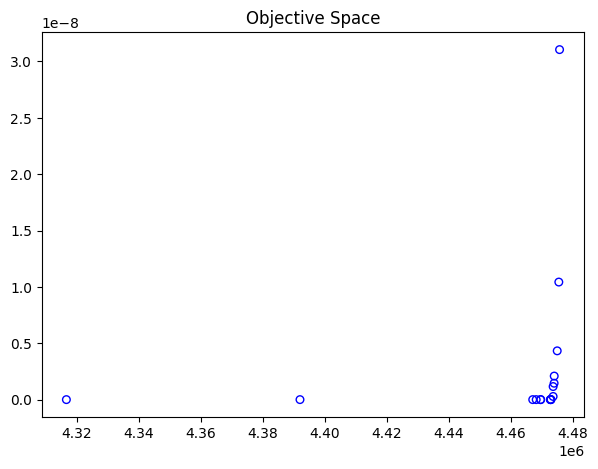

In [30]:
F = res.F
plt.figure(figsize=(7, 5))
plt.scatter(-F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()